# COVID-19 日本における感染者数の推移予測
元データは[WHO発表](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports)より作成。

## 必要なライブラリの読み込み
使用するライブラリは
- pandas : 表データの扱い
- numpy : 数値計算
- matplotlib : グラフを描く
- scipy : 近似用

_import_ で読み込み。_as_ を付けることで、後のコード中でその名前でライブラリに含まれる関数を使うことができる。

_from ライブラリ名 import 関数名_ 句を使うと、巨大なライブラリから特定の関数だけ抜き出して使うことができる。

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

まずは、csvデータからの読み込み。pandasのdataframe型になる。

In [37]:
df = pd.read_csv("COVID_2019.csv")
df

,date,Unnamed: 1,China,Japan,Korea,Singapore,Italy,Germany,France,USA,ref: https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports
0,2020/01/21,Tue.,278.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2020/01/22,Wed.,309.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2020/01/23,Thu.,571.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
3,2020/01/24,Fri.,831.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,NaN
4,2020/01/25,Sat.,1297.0,3.0,2.0,3.0,0.0,0.0,3.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
98,2020/04/28,Tue.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,2020/04/29,Wed.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,2020/04/30,Thu.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,2020/05/01,Fri.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


日本の感染者数の列を抽出して、numpyのndarray型にする。
ついでにdropna()でNaNを削除する。

In [38]:
j_confirmed = df.Japan.dropna().values
j_confirmed

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
       3.0000e+00, 4.0000e+00, 6.0000e+00, 7.0000e+00, 1.1000e+01,
       1.4000e+01, 1.7000e+01, 2.0000e+01, 2.0000e+01, 2.0000e+01,
       2.3000e+01, 2.5000e+01, 2.5000e+01, 2.5000e+01, 2.6000e+01,
       2.6000e+01, 2.6000e+01, 2.8000e+01, 2.9000e+01, 3.3000e+01,
       4.1000e+01, 5.3000e+01, 5.9000e+01, 6.5000e+01, 7.3000e+01,
       8.5000e+01, 9.3000e+01, 1.0500e+02, 1.3200e+02, 1.4400e+02,
       1.5700e+02, 1.6400e+02, 1.8600e+02, 2.1000e+02, 2.3000e+02,
       2.3900e+02, 2.5400e+02, 2.6800e+02, 2.8400e+02, 3.1700e+02,
       3.4900e+02, 4.0800e+02, 4.5500e+02, 4.8800e+02, 5.1400e+02,
       5.6800e+02, 6.2000e+02, 6.7500e+02, 7.1600e+02, 7.8000e+02,
       8.1400e+02, 8.2900e+02, 8.2900e+02, 8.7300e+02, 9.5000e+02,
       9.9600e+02, 1.0460e+03, 1.0890e+03, 1.1280e+03, 1.1930e+03,
       1.2910e+03, 1.3870e+03, 1.4990e+03, 1.6930e+03, 1.8660e+03,
       1.9530e+03, 2.1780e+03, 2.3840e+03, 2.6170e+03, 2.9200e

x軸に並べる日付を準備。

In [39]:
xticks = df.date
x_latent = np.array(range(len(xticks)))

グラフを描画

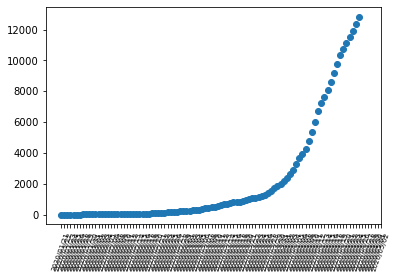

In [40]:
plt.scatter(x_latent[:len(j_confirmed)], j_confirmed, label="Observed")
plt.xticks(x_latent, xticks, fontsize=7, rotation=70);

渡された次数に応じて数式の文字列を作る関数を作成。

In [41]:
def gen_eq_str(coefficients:list, x:str="x", y:str="y"):
    s = ""
    if len(coefficients) == 0:
        s += " 0"
    else:
        for i, coef in enumerate(coefficients):
            if i == len(coefficients) - 1:
                s += " {} {:.2f}".format("+" if coef>0 else "-", np.abs(coef))
            elif i == len(coefficients) - 2:
                s += " {} {:.2f} {}".format("+" if coef>0 else "-", np.abs(coef), x)
            else:
                s += " {} {:.2f} {}^{}".format("+" if coef>0 else "-", np.abs(coef), x, len(coefficients)-i-1)
    if s[1] == "+":
        s = s[2:]
    return "{} ={}".format(y, s)

print(gen_eq_str([-2]))
print(gen_eq_str([1, -2], y="z"))
print(gen_eq_str([5, -6, -7], x="t"))

y = - 2.00
z = 1.00 x - 2.00
y = 5.00 t^2 - 6.00 t - 7.00


渡されたデータ列に対して、指定された範囲で近似曲線を描画する関数を作成。

In [42]:
def draw_approx_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    deg:int, forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]
    coef = np.polyfit(x, y, deg)
    coef[deg] += y_data[r.start]
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = np.poly1d(coef)(x_f - x_data[r.start])
    label = gen_eq_str(coef, x="t")
    label = label[:label.rfind("t")+1]  # omit intercept
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))

指数関数用の近似曲線を描画する関数

In [43]:
def draw_approx_exp_curve(x_data:np.ndarray, y_data:np.ndarray, r:range, 
    forecast:int=14, color:str="green", info:str=""):
    x = [x_data[i] for i in r] - x_data[r.start]
    y = [y_data[i] for i in r] - y_data[r.start]

    def func(x, a, b, c):
        return a*np.exp(x/b)+c
    
    popt, _ = curve_fit(func, x, y, p0=(500,5,0))
    x_f = [x_data[i] for i in range(r.start, r.stop + r.step * forecast, r.step)]
    curve = func((x_f - x_data[r.start]), popt[0], popt[1], popt[2]) + y_data[r.start]
    label = "y = {:.2f} e^(t/{:.2f}) ".format(popt[0], popt[1])
    plt.plot(x_f, curve, c=color, label="{} {}".format(label, info))


データ数が多くなってきたので、ちょっと削る

In [44]:
xj_latent = x_latent[55:]
xjticks = xticks[55:]
j_confirmed = j_confirmed[55:]

予測値を描画
（＊日本で緊急事態宣言が出たのは4/7）

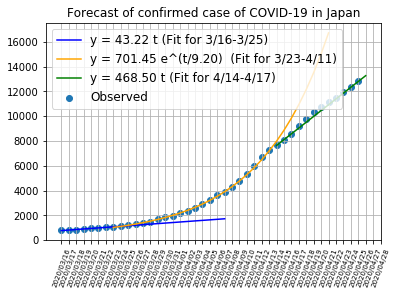

In [45]:
plt.scatter(xj_latent[:len(j_confirmed)], j_confirmed, label="Observed")
plt.xticks(xj_latent, xjticks, fontsize=7, rotation=70);
draw_approx_curve(xj_latent, j_confirmed, range(9), 1, color="blue", info="(Fit for 3/16-3/25)")
#draw_approx_curve(xj_latent, j_confirmed, range(9,25), 2, color="orange", forecast=16, info="(Fit for 3/25-4/10)")
draw_approx_exp_curve(xj_latent, j_confirmed, range(7,25), color="orange", forecast=12, info="(Fit for 3/23-4/11)")
draw_approx_curve(xj_latent, j_confirmed, range(29,32), 1, color="green", forecast=10, info="(Fit for 4/14-4/17)")

plt.legend(fontsize=12)
plt.title("Forecast of confirmed case of COVID-19 in Japan")
plt.grid()

USの傾向のグラフ

USで国家非常事態宣言が出されたのは3/13。カリフォルニア州で外出禁止令が出されたのは3/20。ニューヨーク州で外出禁止令が出されたのは3/22。

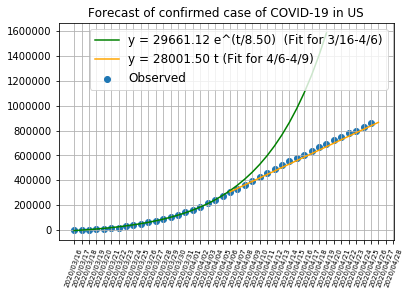

In [46]:
us_confirmed = df.USA.dropna().values
us_confirmed = us_confirmed[55:]
xu_latent = x_latent[55:]
xuticks = xticks[55:]
plt.scatter(xu_latent[:len(us_confirmed)], us_confirmed, label="Observed")
plt.xticks(xu_latent, xuticks, fontsize=7, rotation=70);
draw_approx_exp_curve(xu_latent, us_confirmed, range(21), forecast=14, info="(Fit for 3/16-4/6)")
draw_approx_curve(xu_latent, us_confirmed, range(21,24), 1, forecast=18, color="orange", info="(Fit for 4/6-4/9)")
plt.legend(fontsize=12)
plt.title("Forecast of confirmed case of COVID-19 in US")
plt.grid()

各国の新規感染者数の推移

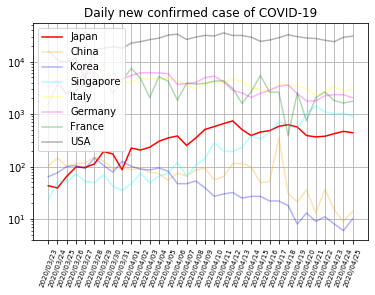

In [47]:
df_new = df[{"China", "Japan", "Korea", "Singapore", "Italy", "Germany", "France", "USA"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
df_new = df_new[62:]
#print(df_new)
plt.plot(df_new["date"], df_new["Japan"], color="red", label="Japan")
plt.plot(df_new["date"], df_new["China"], color="orange", alpha=0.3, label="China")
plt.plot(df_new["date"], df_new["Korea"], color="blue", alpha=0.3, label="Korea")
plt.plot(df_new["date"], df_new["Singapore"], color="cyan", alpha=0.3, label="Singapore")
plt.plot(df_new["date"], df_new["Italy"], color="yellow", alpha=0.3, label="Italy")
plt.plot(df_new["date"], df_new["Germany"], color="magenta", alpha=0.3, label="Germany")
plt.plot(df_new["date"], df_new["France"], color="green", alpha=0.3, label="France")
plt.plot(df_new["date"], df_new["USA"], color="black", alpha=0.3, label="USA")

plt.xticks(range(len(df_new["date"])-7), df_new["date"], fontsize=7, rotation=70);
plt.yscale("log");
plt.grid();
plt.legend(loc="upper left");
plt.title("Daily new confirmed case of COVID-19");


日本の新規感染者数

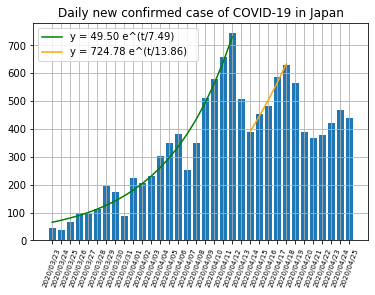

In [48]:
plt.bar(df_new["date"], df_new["Japan"])
draw_approx_exp_curve(np.array(range(21)), df_new["Japan"].dropna().values, range(21), forecast=0, info="")
draw_approx_exp_curve(np.array(range(27)), df_new["Japan"].dropna().values, range(22,27), forecast=0, color="orange", info="")
plt.xticks(range(len(df_new["date"])-7), df_new["date"], fontsize=7, rotation=70);
plt.grid();
plt.legend()
plt.title("Daily new confirmed case of COVID-19 in Japan");

累積感染者数が10,000人を超えてから10日間の経過

Text(0.5, 1.0, 'Numbers of the day after counting 10,000 cases')

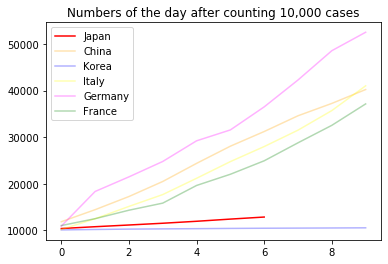

In [49]:
plt.plot(range(7), df[df["Japan"] > 10000]["Japan"][:7], color="red", label="Japan")
plt.plot(range(10), df[df["China"] > 10000]["China"][:10], color="orange", alpha=0.3, label="China")
plt.plot(range(10), df[df["Korea"] > 10000]["Korea"][:10], color="blue", alpha=0.3, label="Korea")
plt.plot(range(10), df[df["Italy"] > 10000]["Italy"][:10], color="yellow", alpha=0.3, label="Italy")
plt.plot(range(10), df[df["Germany"] > 10000]["Germany"][:10], color="magenta", alpha=0.3, label="Germany")
plt.plot(range(10), df[df["France"] > 10000]["France"][:10], color="green", alpha=0.3, label="France")
#plt.plot(range(5), df[df["USA"] > 5000]["USA"][:5], color="black", alpha=0.3, label="USA")

plt.legend()
plt.title("Numbers of the day after counting 10,000 cases")

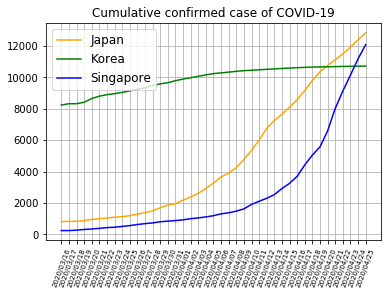

In [50]:
plt.plot(xj_latent[:len(j_confirmed)], j_confirmed, color="orange", label="Japan")
plt.plot(xj_latent[:len(j_confirmed)], df.Korea.dropna().values[55:], color="green", label="Korea")
plt.plot(xj_latent[:len(j_confirmed)], df.Singapore.dropna().values[55:], color="blue", label="Singapore")
plt.xticks(xj_latent[:-7], xjticks, fontsize=7, rotation=70);

plt.legend(fontsize=12)
plt.title("Cumulative confirmed case of COVID-19")
plt.grid()

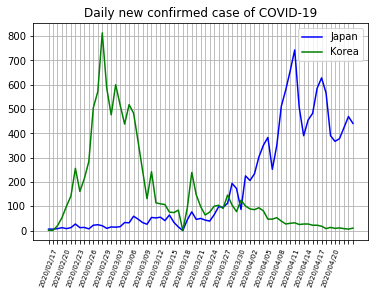

In [51]:
df_new = df[{"China", "Korea", "Japan"}].diff()
df_new = pd.concat([df["date"], df_new], axis=1)
df_new = df_new[27:]

plt.plot(df_new.date.dropna().values[:-7], df_new.Japan.dropna().values, color="blue", label="Japan")
plt.plot(df_new.date.dropna().values[:-7], df_new.Korea.dropna().values, color="green", label="Korea")
xti = [df_new["date"].values[i] if i%3==0  else "" for i in range(len(df_new["date"]) - 10)]
plt.xticks(range(len(df_new["date"])-7), xti, fontsize=7, rotation=70);
plt.grid();
plt.legend()
plt.title("Daily new confirmed case of COVID-19");
